In [154]:
import pandas as pd  # dataframe Series等的操作
import numpy as np  # 一些函数，如log等    
from fbprophet import Prophet  # facebook prophet 框架对象
from sklearn.metrics import mean_squared_error  # 均值方差错误检测函数 sklearn包中有很多其他函数
from fbprophet.diagnostics import cross_validation  # 交叉验证函数

In [155]:
df = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20141231.csv')
print(type(df))

df1 = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20151231.csv')
df_evaluate = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20161231.csv')
df_test = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20171231.csv')

df_2_years = pd.concat([df, df1])
df_train = pd.concat([df, df1, df_evaluate])
df = pd.concat([df, df1, df_evaluate,df_test])  

df_train = df_train[df_train.columns[0:2]]
df_train.columns = ['ds', 'y']
df_train.y = df_train.y.str.replace("$","")
df_train.y = df_train.y.astype(float)
df_train['y'] = np.log(df_train['y'])


df_train = df_train[df_train.columns[0:2]]
df_train.columns = ['ds', 'y']
df_train.y = df_train.y.str.replace("$","")
df_train.y = df_train.y.astype(float)
df_train['y'] = np.log(df_train['y'])



df = df[df.columns[0:2]]
df.columns = ['ds', 'y']
print(type(df.y))
print(df.y.str)
#去除$
df.y = df.y.str.replace("$","")
#str 转float 
df.y = df.y.astype(float)
# 取指数，达成正态分布？
df['y'] = np.log(df['y'])
#df['cap'] = 20
#print(df)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [156]:
christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25']),
  'lower_window': 0,
  'upper_window': 3,
})

thanksgiving = pd.DataFrame({
  'holiday': 'thanksgiving',
  'ds': pd.to_datetime(['2014-11-27', '2015-11-26', '2016-11-24', '2017-11-23']),
  'lower_window': 0,
  'upper_window': 5,
})

holidays = pd.concat((christmas, thanksgiving))
# 

# mcmc_samples = 200
m = Prophet(changepoint_prior_scale=0.05, holidays = holidays, yearly_seasonality=True,
           holidays_prior_scale=0.95, interval_width=0.95)
m.fit(df);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.5/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [157]:
# period一定为准确的年份倍数，若三个参数均为年份
df_cv = cross_validation(m, horizon = '365 days', period = '1096 days', initial='0 days')
print(df_cv)

/usr/local/lib/python3.5/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


            ds       yhat  yhat_lower  yhat_upper          y     cutoff
0   2017-01-01  16.841973   16.288118   17.413341  16.446089 2016-12-31
1   2017-01-02  16.403470   15.858379   16.923611  16.722364 2016-12-31
2   2017-01-03  16.273835   15.763701   16.772198  15.997600 2016-12-31
3   2017-01-04  16.394209   15.804494   16.928559  15.846492 2016-12-31
4   2017-01-05  16.250456   15.772375   16.754189  16.401117 2016-12-31
5   2017-01-06  16.349721   15.846800   16.900666  16.346137 2016-12-31
6   2017-01-07  16.491817   15.935907   17.006385  16.513524 2016-12-31
7   2017-01-08  16.669795   16.136095   17.200589  16.631674 2016-12-31
8   2017-01-09  16.248087   15.726197   16.777037  16.252559 2016-12-31
9   2017-01-10  16.134386   15.600932   16.687181  16.194947 2016-12-31
10  2017-01-11  16.269811   15.765231   16.778447  16.335021 2016-12-31
11  2017-01-12  16.140237   15.598909   16.661315  15.723349 2016-12-31
12  2017-01-13  16.252858   15.709620   16.770172  16.501436 201

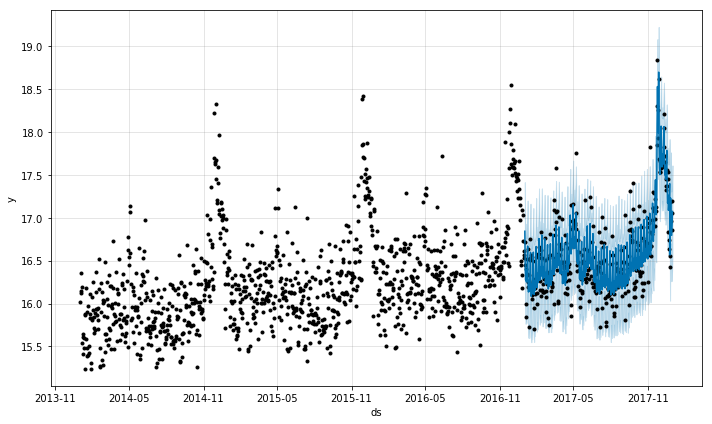

In [158]:
m.plot(df_cv);

In [159]:
mse = mean_squared_error(df.y[1096:], df_cv.yhat)
print(mse)
mape = np.median(np.true_divide(np.abs(df_cv.yhat.sub(df.y[1096:])), df.y[1096:]))
#mape = median_absolute_percentage_error(df.y, forecast.yhat[0:1461])
print(mape)

0.07996802433170563
0.010963301407074487


In [112]:
?cross_validation

In [162]:
result = dict()
result['time_period'] = '2017'
result['mse'] = mse
result['mape'] = mape
pd.DataFrame(result, index=[0])

,mape,mse,time_period
0,0.010963,0.079968,2017


In [278]:
future = m.make_future_dataframe(periods=731)
#future['cap'] = 20
future.tail()

,ds
2187,2019-12-28
2188,2019-12-29
2189,2019-12-30
2190,2019-12-31
2191,2020-01-01


In [279]:
forecast = m.predict(future)
print(type(forecast))
forecast.tail()
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#forecast[(forecast['christmas'] + forecast['thanksgiving']).abs() > 0][
 #       ['ds', 'christmas', 'thanksgiving']][-10:]

<class 'pandas.core.frame.DataFrame'>


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,christmas,christmas_lower,christmas_upper,holidays,...,thanksgiving,thanksgiving_lower,thanksgiving_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
2187,2019-12-28,17.025603,16.989668,17.058325,16.680939,18.033859,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.120134,0.120134,0.120134,0.190197,0.190197,0.190197,17.335934
2188,2019-12-29,17.026105,16.990093,17.058905,16.793150,18.270092,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.307921,0.307921,0.307921,0.145707,0.145707,0.145707,17.479733
2189,2019-12-30,17.026607,16.990519,17.059486,16.417912,17.773190,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.052488,-0.052488,-0.052488,0.104124,0.104124,0.104124,17.078243
2190,2019-12-31,17.027109,16.990945,17.060066,16.266132,17.651399,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.155747,-0.155747,-0.155747,0.065512,0.065512,0.065512,16.936874
2191,2020-01-01,17.027611,16.991371,17.060646,16.363363,17.675102,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.034574,-0.034574,-0.034574,0.029876,0.029876,0.029876,17.022913


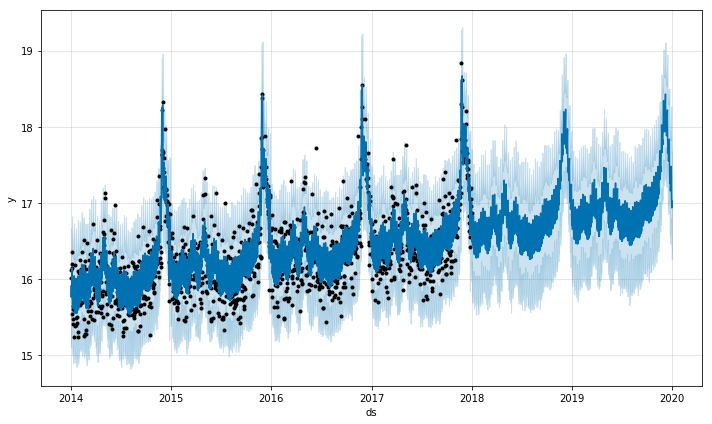

In [280]:
m.plot(forecast);

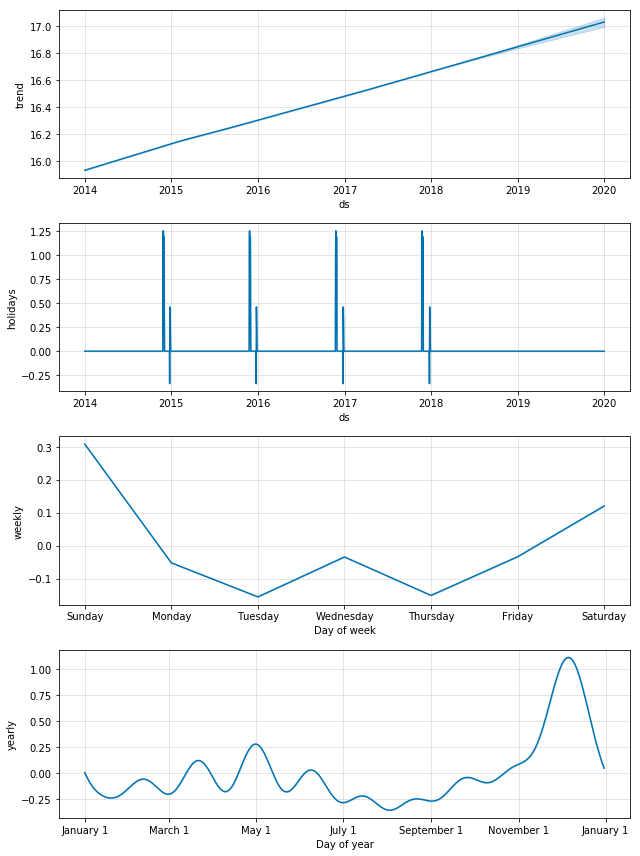

In [281]:
m.plot_components(forecast);

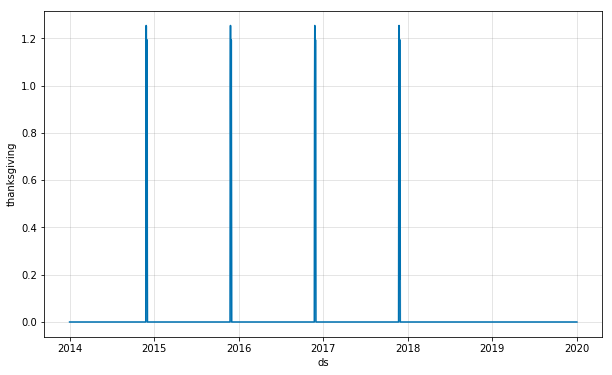

In [282]:
m.plot_forecast_component(forecast, 'thanksgiving')

In [283]:
m.predictive_samples(future)

{'seasonal': array([[-0.02141089, -0.02141089, -0.02141089, ..., -0.02141089,
         -0.02141089, -0.02141089],
        [-0.16938501, -0.16938501, -0.16938501, ..., -0.16938501,
         -0.16938501, -0.16938501],
        [-0.08053336, -0.08053336, -0.08053336, ..., -0.08053336,
         -0.08053336, -0.08053336],
        ...,
        [ 0.05163616,  0.05163616,  0.05163616, ...,  0.05163616,
          0.05163616,  0.05163616],
        [-0.09023474, -0.09023474, -0.09023474, ..., -0.09023474,
         -0.09023474, -0.09023474],
        [-0.00469773, -0.00469773, -0.00469773, ..., -0.00469773,
         -0.00469773, -0.00469773]]),
 'trend': array([[15.93306004, 15.93306004, 15.93306004, ..., 15.93306004,
         15.93306004, 15.93306004],
        [15.93359783, 15.93359783, 15.93359783, ..., 15.93359783,
         15.93359783, 15.93359783],
        [15.93413563, 15.93413563, 15.93413563, ..., 15.93413563,
         15.93413563, 15.93413563],
        ...,
        [17.00813321, 17.00895725

In [284]:
mse = mean_squared_error(df.y, forecast.yhat[0:1461])

print(mse)

0.07517088296638191


In [285]:
# ??为什么sub后还要slice[0:1461]??
mape = np.median(np.true_divide(np.abs(forecast.yhat[0:1461].sub(df.y)[0:1461]), df.y))
#mape = median_absolute_percentage_error(df.y, forecast.yhat[0:1461])
print(mape)

0.019796189189902082
